In [1]:
from pathlib import Path
import pickle
import copy

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.4+0.x64.w64.mingw32. You currently have `1.10.3+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd()

# Setting up the system

In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=1
    ),
    transitions.MicrowaveTransition(J_ground=1, J_excited=0),
]

polarizations = [
    [couplings.polarization_X, couplings.polarization_Y],
    [couplings.polarization_Z, couplings.polarization_X],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [5]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    δ0=0.0,
    Ω1=hamiltonian.Γ,
    δ1=0.0,
    # polarization modulation
    Pl="sin(ωl*t+ϕl)",
    PX0="Pl>=0",
    PY0="Pl<0",
    Pm="sin(ωm*t+ϕm)",
    PZ1="Pm>=0",
    PX1="Pm<0",
    ωl=2 * np.pi * 1e6,
    ϕl=0.0,
    ωm=2 * np.pi * 1e6,
    ϕm=np.pi / 2,
)

In [6]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=states.QuantumSelector(J=3, electronic=states.ElectronicState.X),
    decay_channels=None,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 26.9 s
Wall time: 45.1 s


In [8]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_original, transition_selectors, odepars
)

In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 1>",0.999873
"|X, J = 3>",0.000127


In [10]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X), obe_system.QN
)

# Single trajectory; only laser

In [11]:
odepars.Ω0 = hamiltonian.Γ
odepars.Ω1 = 0.0
odepars.δ0 = 2.0 * hamiltonian.Γ
odepars.δ1 = 0.0
odepars.ωl = 2 * np.pi * 0.3e6
odepars.ωm = 2 * np.pi * 0.3e6

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 50e-6))
config = lindblad_julia.OBEProblemConfig(method="Tsit5()", saveat=1e-6)

results = lindblad_julia.do_simulation_single(problem, config=config)

In [12]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J1 = states.QuantumSelector(J=1, electronic=states.ElectronicState.X)
indices_J1 = qn_select_J1.get_indices(obe_system.QN)

qn_select_J0 = states.QuantumSelector(J=0, electronic=states.ElectronicState.X)
indices_J0 = qn_select_J0.get_indices(obe_system.QN)

6.07 photons


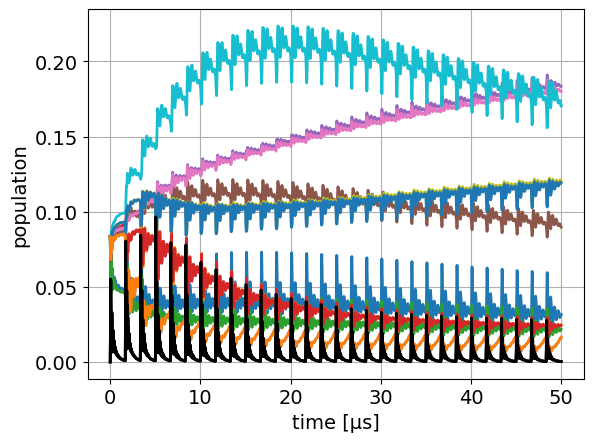

In [13]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J1].T, lw=2)
ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

# Single Trajectory; laser and microwave

In [14]:
odepars.Ω0 = hamiltonian.Γ / 2
odepars.Ω1 = hamiltonian.Γ / 2
odepars.δ0 = 0.85 * hamiltonian.Γ
odepars.δ1 = 0.0

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 100e-6))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

results = lindblad_julia.do_simulation_single(problem, config=config)

23.29 photons


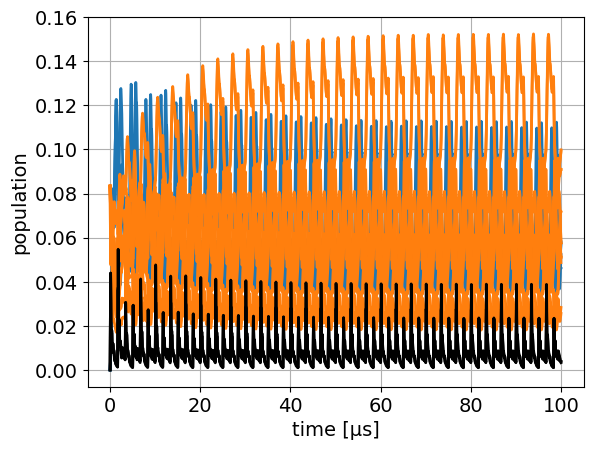

In [15]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J0].T, lw=2, color="C0")
ax.plot(results.t * 1e6, results.y[indices_J1].T, lw=2, color="C1")
ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

# Ensemble problem, changing powers and frequency

In [18]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [19]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

In [45]:
rabis = np.linspace(0, 2 * hamiltonian.Γ, 21)
frequencies = np.linspace(0, 2 * hamiltonian.Γ, 21)

odepars.δ0 = 0.0
odepars.δ1 = 0.0

In [46]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    abstol=1e-10,
    reltol=1e-7,
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 100e-6))

scan_values = np.array(np.meshgrid(rabis, rabis, frequencies, indexing="ij")).T.reshape(
    -1, 3
)
scan_values = [
    scan_values[:, 0],
    scan_values[:, 1],
    scan_values[:, 2],
    scan_values[:, 2],
]
parameters = ["Ω0", "Ω1", "ωl", "ωm"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
    zipped=True,
)

lindblad_julia.setup_problem_parameter_scan(ensemble_problem)

In [47]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

CPU times: total: 3.31 s
Wall time: 1h 15min 15s


In [49]:
results = lindblad_julia.get_results_parameter_scan(ensemble_problem)

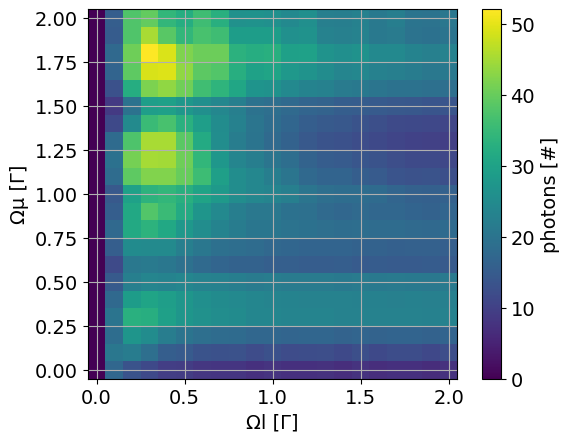

In [88]:
flattened_grid = rabis.size * rabis.size
X, Y = np.array(np.meshgrid(rabis, rabis)) / hamiltonian.Γ

i = 3
z = results.results[i * flattened_grid : (i + 1) * flattened_grid].reshape(
    rabis.size, rabis.size
)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, z)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("photons [#]")
ax.set_xlabel("Ωl [Γ]")
ax.set_ylabel("Ωμ [Γ]")
ax.set_aspect(1.0)
ax.grid()

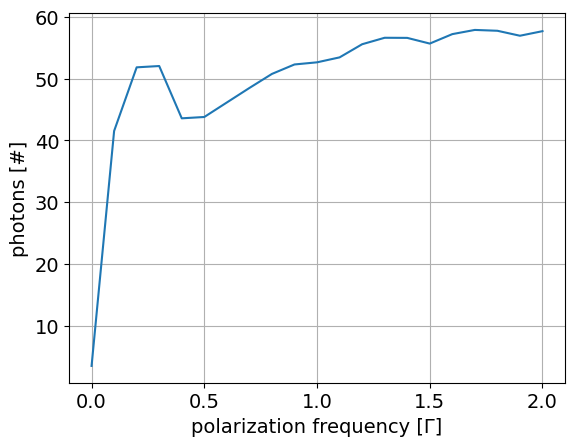

In [81]:
max_photons = np.empty(frequencies.size)
for i in range(frequencies.size):
    z = results.results[i * flattened_grid : (i + 1) * flattened_grid].reshape(
        rabis.size, rabis.size
    )
    max_photons[i] = z.max()

fig, ax = plt.subplots()
ax.plot(frequencies / hamiltonian.Γ, max_photons)
ax.set_xlabel("polarization frequency [Γ]")
ax.set_ylabel("photons [#]")
ax.grid()

In [26]:
from typing import List, Optional, Sequence
import sympy as smp

Ωs = [t.Ω for t in transition_selectors]
δs = [t.δ for t in transition_selectors]
pols: List[Optional[Sequence[smp.Symbol]]] = []
for transition in transition_selectors:
    if not transition.polarization_symbols:
        pols.append(None)
    else:
        pols.append(transition.polarization_symbols)


In [29]:
H_int = obe_system.H_int
n_states = H_int.shape[0]
# initialize empty hamiltonian
ham = smp.zeros(*H_int.shape)
energies = smp.symbols(f"E:{n_states}")
ham += smp.eye(n_states) * np.asarray(energies)

# generate t symbol for non-rotating frame
t = smp.Symbol("t", real=True)

# iterate over couplings
for idc, (Ω, coupling) in enumerate(zip(Ωs, obe_system.couplings_original)):
    # generate transition frequency symbol
    ω = smp.Symbol(f"ω{idc}", real=True)
    # main coupling matrix element
    main_coupling = coupling.main_coupling
    # iterate over fields (polarizations) in the coupling
    for idf, field in enumerate(coupling.fields):
        if pols:
            P = pols[idc]
            if P:
                _P = P[idf]
                val = (_P * Ω / main_coupling) / 2
                for i, j in zip(*np.nonzero(field.field)):
                    if i < j:
                        ham[i, j] += val * field.field[i, j] * smp.exp(1j * ω * t)
                        ham[j, i] += val * field.field[j, i] * smp.exp(-1j * ω * t)
            else:
                val = (Ω / main_coupling) / 2
                for i, j in zip(*np.nonzero(field.field)):
                    if i < j:
                        ham[i, j] += val * field.field[i, j] * smp.exp(1j * ω * t)
                        ham[j, i] += val * field.field[j, i] * smp.exp(-1j * ω * t)
        else:
            val = (Ω / main_coupling) / 2
            for i, j in zip(*np.nonzero(field.field)):
                if i < j:
                    ham[i, j] += val * field.field[i, j] * smp.exp(1j * ω * t)
                    ham[j, i] += val * field.field[j, i] * smp.exp(-1j * ω * t)

ham = smp.simplify(ham)


In [62]:
energies = np.diag(ham)

coupled_states = []
for i, j in zip(*np.nonzero(ham)):
    if i < j:
        syms = ham[i, j].free_symbols
        syms = [s for s in syms if str(s)[0] == "ω"]
        assert len(syms) == 1, f"Too many/few couplings, syms = {syms}"
        coupled_states.append((i, j, syms[0]))

# solve equations to generate unitary transformation to rotating frame
A = smp.symbols(f"a:{n_states}")
Eqns = []
# generate equations
for i, j, ω in coupled_states:
    Eqns.append(ω - (A[i] - A[j]))
# solve system of equations
sol = smp.solve(Eqns, A)
# set free parameters to zero in the solution
free_params = [value for value in A if value not in list(sol.keys())]
for free_param in free_params:
    for key, val in sol.items():
        sol[key] = val.subs(free_param, 0)

# generate unitary transformation matrix
T = smp.eye(*H_int.shape)
for var in sol.keys():
    ida = int(str(var)[1:])
    T[ida, ida] = smp.exp(1j * sol[var] * t)


In [66]:
# use unitary matrix to transform to rotating frame
transformed = T.adjoint() @ ham @ T - 1j * T.adjoint() @ smp.diff(T, t)
transformed = smp.simplify(transformed)

transformed = smp.Matrix(transformed)

transformed_before_subs = copy.deepcopy(transformed)


In [67]:
for idc, (δ, coupling) in enumerate(zip(δs, obe_system.couplings_original)):
    # generate transition frequency symbol
    ω = smp.Symbol(f"ω{idc}", real=True)
    # get indices of ground and excited states
    idg = obe_system.QN_original.index(coupling.ground_main)
    ide = obe_system.QN_original.index(coupling.excited_main)
    # transform to δ instead of ω and E
    if idg < ide:
        transformed = transformed.subs(ω, energies[ide] - energies[idg] + δ)
    elif idg > ide:
        transformed = transformed.subs(ω, energies[idg] - energies[ide] + δ)

for idc, (δ, coupling) in enumerate(zip(δs, obe_system.couplings_original)):
    idg = obe_system.QN_original.index(coupling.ground_main)
    expr = transformed[idg, idg]
    for d in δs:
        expr = expr.subs(d, 0)

    for idx in range(transformed.shape[0]):
        transformed[idx, idx] -= expr

# substitute level energies for symbolic values
transformed = transformed.subs([(E, val) for E, val in zip(energies, np.diag(H_int))])


In [69]:
for l in np.diag(transformed):
    print(l)


1.0*δ0 + 1.0*δ1 + 83566.3655475656
1.0*δ0 + 1.0*δ1 + 0.20383472699541
1.0*δ0 + 1.0*δ1
1.0*δ0 + 1.0*δ1 - 0.203834671978257
1.0*δ0 - 1336622.01002502
1.0*δ0 - 1196891.51081848
1.0*δ0 - 1196891.61772156
1.0*δ0 - 1196891.72485352
1.0*δ0 - 91349.8665618896
1.0*δ0 - 91349.8649902344
1.0*δ0 - 91349.8631134033
1.0*δ0 + 0.205947875976563
1.0*δ0 + 0.102859497070313
1.0*δ0
1.0*δ0 - 0.103164672851563
1.0*δ0 - 0.206100463867188
508268087487.146
508268087487.214
508268087487.282
508268087487.348
508268087487.414
508268489265.316
508268489265.291
508268489265.267
508268489265.242
508268489265.218
508268489265.193
508268489265.169
508270905653.273
508270905653.280
508270905653.286
508270905653.293
508270905653.299
508270905653.305
508270905653.312
508271247322.320
508271247322.271
508271247322.218
508271247322.166
508271247322.115
508271247322.064
508271247322.012
508271247321.961
508271247321.909
56.5186977386475
28.2593564987183
0


In [ ]:
for l in np.diag(transformed_before_subs):
    print(smp.nsimplify(l))


E0 + ω0 + ω1
E1 + ω0 + ω1
E2 + ω0 + ω1
E3 + ω0 + ω1
E4 + ω0
E5 + ω0
E6 + ω0
E7 + ω0
E8 + ω0
E9 + ω0
E10 + ω0
E11 + ω0
E12 + ω0
E13 + ω0
E14 + ω0
E15 + ω0
E16
E17
E18
E19
E20
E21
E22
E23
E24
E25
E26
E27
E28
E29
E30
E31
E32
E33
E34
E35
E36
E37
E38
E39
E40
E41
E42
E43
E44
E45
E46
